# Deepfake Image Detector Using DL

**Download the dataset from Kaggle using kagglehub**

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")

print("Path to dataset files:", path)

100%|██████████| 1.68G/1.68G [01:09<00:00, 26.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1


You might need to run the above kagglehub cell again to download the dataset.

**Import the required libraries**

In [77]:
# Core Libraries
import numpy as np
import tensorflow as tf

# CNN, CapsNet, and Functional API Tools
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import Layer, Lambda, Reshape, BatchNormalization, Softmax
from tensorflow.keras import layers, models

# Xception Model (Transfer Learning)
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model

# Visualization
import matplotlib.pyplot as plt

# Utilities for Handling Image Files and Paths
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


**Load the images from the Train, Validation, and Test directories**

In [ ]:
# Define the paths for Train, Validation, and Test directories
dataset_path = "/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset"
train_path = os.path.join(dataset_path, 'Train')
val_path = os.path.join(dataset_path, 'Validation')
test_path = os.path.join(dataset_path, 'Test')

# Function to load datasets using TensorFlow's API
def load_tf_dataset(data_path, batch_size=32, img_size=(299, 299)):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        label_mode='binary',   # For Real/Fake classification
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True  # Shuffle the dataset to improve training performance
    )
    return dataset

# Load Train, Validation, and Test datasets
train_dataset = load_tf_dataset(train_path)
val_dataset = load_tf_dataset(val_path)
test_dataset = load_tf_dataset(test_path)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [ ]:
# Check class names
print(f"Train Class Names: {train_dataset.class_names}")
print(f"Validation Class Names: {val_dataset.class_names}")
print(f"Test Class Names: {test_dataset.class_names}")

Train Class Names: ['Fake', 'Real']
Validation Class Names: ['Fake', 'Real']
Test Class Names: ['Fake', 'Real']


## Exploratory Data Analysis (EDA)

**1. Class Distribution Plot**

To ensure that the dataset is balanced (i.e., equal or close number of 'Real' and 'Fake' images are present)

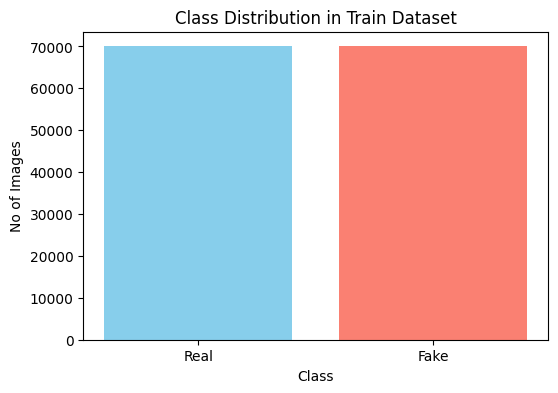

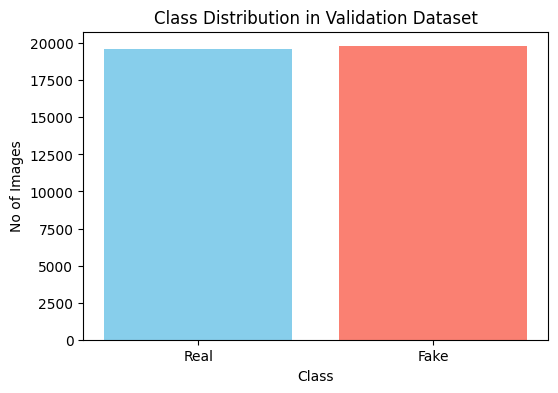

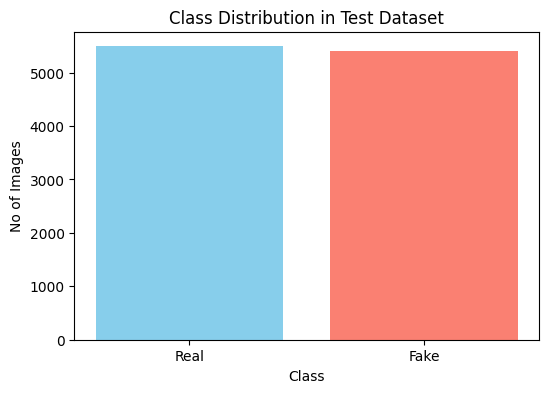

In [ ]:
def plot_class_distribution(dataset, dataset_name):
    # Collect all labels in a list
    labels = []
    for _, batch_labels in dataset:
        labels.extend(batch_labels.numpy())

    # Calculate the count of each class (Real=0, Fake=1)
    real_count = labels.count(0)
    fake_count = labels.count(1)

    # Plot the class distribution
    plt.figure(figsize=(6, 4))
    plt.bar(['Real', 'Fake'], [real_count, fake_count], color=['skyblue', 'salmon'])
    plt.xlabel('Class')
    plt.ylabel('No of Images')
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.show()

# Plot class distributions for Train, Validation, and Test datasets
plot_class_distribution(train_dataset, "Train")
plot_class_distribution(val_dataset, "Validation")
plot_class_distribution(test_dataset, "Test")


From the bar graphs, we can see that the dataset is balanced (number of 'Real' and 'Fake' images are equal)

**2. Display Some Sample Images**

To confirm that the images are loaded correctly and match their labels.

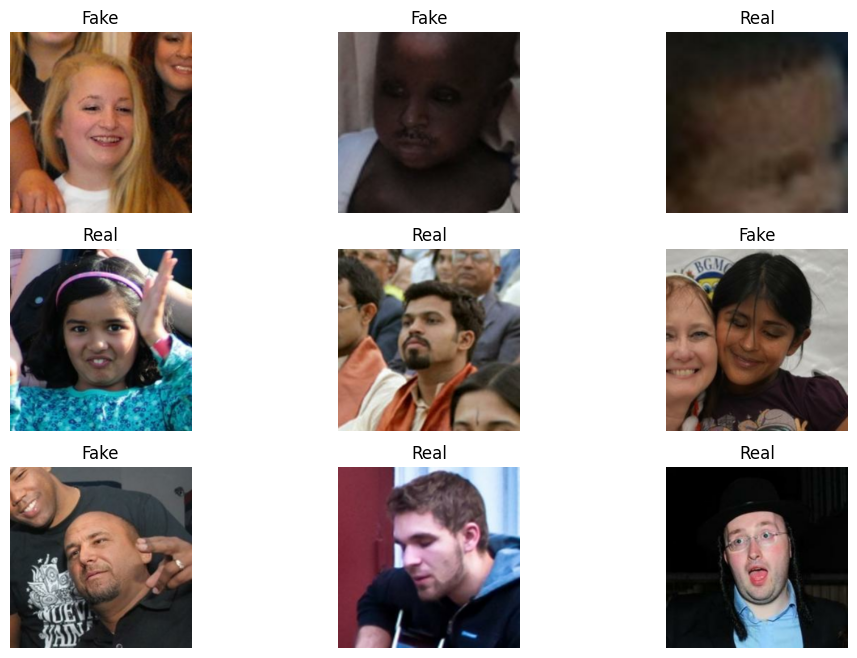

In [ ]:
def show_samples(dataset, class_names, num_samples=6):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"{class_names[int(labels[i])]}")
            plt.axis("off")

# Display 9 samples from the Train dataset
show_samples(train_dataset, train_dataset.class_names, num_samples=9)



**3. Check Image Shapes and Label Types**

In [ ]:
for images, labels in train_dataset.take(1):  # Display the shape of one batch
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Label Data Type: {labels.dtype}")

Image batch shape: (32, 299, 299, 3)
Label batch shape: (32, 1)
Label Data Type: <dtype: 'float32'>


**4. Plot the Pixel Value Distribution**

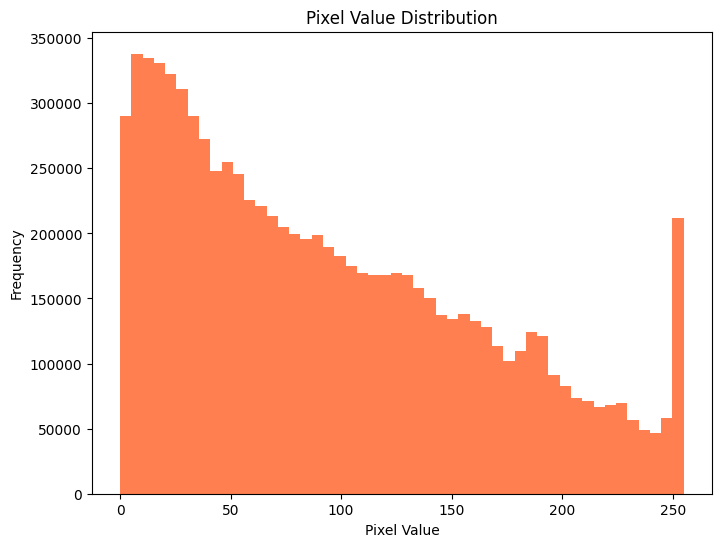

In [ ]:
def plot_pixel_distribution(dataset):
    pixel_values = []
    for images, _ in dataset.take(1):
        pixel_values.extend(images.numpy().flatten())

    plt.figure(figsize=(8, 6))
    plt.hist(pixel_values, bins=50, color='coral')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Value Distribution')
    plt.show()

# Plot the pixel distribution for the Train dataset
plot_pixel_distribution(train_dataset)

## Model 1: CNN

In [ ]:
# Define CNN model architecture
def create_cnn_model(input_shape=(299, 299, 3)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Create an instance of the CNN model
cnn_model = create_cnn_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Display the model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 297, 297, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 156800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      10,035,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,385,733 (115.91 MB)

 Trainable params: 10,128,577 (38.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,257,156 (77.27 MB)

In [ ]:
# Since the dataset is very huge, we are only taking a subset of the Train, Validation and Test datasets
subset_size = 15
train_subset = train_dataset.take(subset_size)
val_subset = val_dataset.take(subset_size)
test_subset = test_dataset.take(subset_size)

# Apply caching and prefetching for performance
train_subset = train_subset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_subset = val_subset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_subset = test_subset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# model training
history = cnn_model.fit(train_subset, epochs=5, validation_data=val_subset)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.5241 - loss: 306.3097 - val_accuracy: 0.5146 - val_loss: 0.7070
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 117s 8s/step - accuracy: 0.6280 - loss: 0.6742 - val_accuracy: 0.6187 - val_loss: 0.6598
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.7789 - loss: 0.4991 - val_accuracy: 0.6500 - val_loss: 0.6514
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.8982 - loss: 0.3233 - val_accuracy: 0.6646 - val_loss: 0.6977
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.9414 - loss: 0.2004 - val_accuracy: 0.6104 - val_loss: 1.2980
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6308 - loss: 1.1952


In [ ]:
# Evaluate the model on the test set
loss, accuracy = cnn_model.evaluate(test_subset)
# Results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6308 - loss: 1.1952
Test Loss: 1.2989
Test Accuracy: 0.5958


## Model 2: CapsNets

In [ ]:
# Custom squash function for non-linear activation
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

# Capsule Layer with correct batch_dot dimensions
class CapsuleLayer(Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.num_capsules * self.dim_capsule),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        # Reshape inputs for correct batch_dot alignment
        u_hat = K.dot(inputs, self.kernel)
        u_hat = K.reshape(u_hat, (-1, inputs.shape[1], self.num_capsules, self.dim_capsule))

        b = K.zeros_like(u_hat[:, :, :, 0])  # Initialize routing logits

        # Dynamic routing process
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)  # Softmax over the num_capsules dimension
            s = K.sum(c[..., None] * u_hat, axis=1)  # Weighted sum across capsules
            v = squash(s)  # Squash to unit length
            if i < self.routings - 1:
                b += K.sum(u_hat * v[:, None, :, :], axis=-1)  # Update logits

        return v

# Define the CapsNet architecture
def create_capsnet(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    # First convolutional layer
    conv1 = Conv2D(64, (9, 9), strides=2, padding='valid', activation='relu')(inputs)

    # Primary Capsule Layer
    primary_caps = Conv2D(128, (9, 9), strides=2, padding='valid', activation='relu')(conv1)
    primary_caps = Reshape((-1, 8))(primary_caps)

    # Capsule Layer with routing
    caps_layer = CapsuleLayer(num_capsules=n_classes, dim_capsule=16, routings=3)(primary_caps)

    # Output layer: Compute the length of capsule vectors for class probabilities
    outputs = Lambda(lambda z: K.sqrt(K.sum(K.square(z), axis=-1)))(caps_layer)

    # Add a Dense layer to ensure correct output shape
    outputs = Dense(n_classes, activation='softmax')(outputs)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the CapsNet model instance
capsnet_model = create_capsnet(input_shape=(299, 299, 3), n_classes=2)

In [ ]:
# Display the model summary
capsnet_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 146, 146, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 69, 69, 128)         │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_13 (Reshape)                 │ (None, 76176, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_layer_13 (CapsuleLayer)      │ (None, 2, 16)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,038,676 (7.78 MB)

 Trainable params: 679,558 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,359,118 (5.18 MB)

In [ ]:
# Prepare data subsets
subset_size = 15
train_subset = train_dataset.take(subset_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_subset = val_dataset.take(subset_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_subset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the CapsNet model
history = capsnet_model.fit(train_subset, epochs=5, validation_data=val_subset)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 373s 25s/step - accuracy: 0.4892 - loss: 0.7049 - val_accuracy: 0.5562 - val_loss: 0.6868
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 363s 25s/step - accuracy: 0.4892 - loss: 0.7017 - val_accuracy: 0.5562 - val_loss: 0.6870
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 386s 25s/step - accuracy: 0.4892 - loss: 0.6995 - val_accuracy: 0.5562 - val_loss: 0.6873
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 431s 28s/step - accuracy: 0.4892 - loss: 0.6980 - val_accuracy: 0.5562 - val_loss: 0.6878
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 443s 28s/step - accuracy: 0.4892 - loss: 0.6969 - val_accuracy: 0.5562 - val_loss: 0.6883


In [ ]:
# Evaluate the model on the test set
test_subset = test_subset.take(subset_size)
loss, accuracy = capsnet_model.evaluate(test_subset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 92s 6s/step - accuracy: 0.4779 - loss: 0.6975
Test Loss: 0.6988
Test Accuracy: 0.4667


## Model 3: Xception

In [ ]:
# Load the Xception model with pre-trained weights, excluding the top layers
def create_xception_model(input_shape=(299, 299, 3), n_classes=2):
    # Load the base model with ImageNet weights and exclude the top layers
    base_model = Xception(
        weights='imagenet',
        include_top=False,  # Exclude fully connected layers
        input_shape=input_shape
    )

    # Freeze the base model layers to retain pre-trained weights
    base_model.trainable = False

    # Add custom top layers for binary classification
    inputs = Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Return both the full model and the base model for later fine-tuning
    return model, base_model

# Create the Xception model instance
xception_model, base_model = create_xception_model()

In [ ]:
# Display the model summary
xception_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_3 (TrueDivide)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_3 (Subtract)                │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Prepare data subsets for training, validation, and testing
subset_size = 15
train_subset = train_dataset.take(subset_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_subset = val_dataset.take(subset_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the Xception model
history = xception_model.fit(train_subset, epochs=5, validation_data=val_subset)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 396s 27s/step - accuracy: 0.5520 - loss: 0.6998 - val_accuracy: 0.6104 - val_loss: 0.6576
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 394s 27s/step - accuracy: 0.7909 - loss: 0.4709 - val_accuracy: 0.7229 - val_loss: 0.5633
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 427s 26s/step - accuracy: 0.8513 - loss: 0.3779 - val_accuracy: 0.7229 - val_loss: 0.5692
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 386s 26s/step - accuracy: 0.8969 - loss: 0.3173 - val_accuracy: 0.7312 - val_loss: 0.5624
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 452s 27s/step - accuracy: 0.9405 - loss: 0.2677 - val_accuracy: 0.7146 - val_loss: 0.5905


In [75]:
# Evaluate the model on the test set
test_subset = test_subset.take(subset_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
loss, accuracy = xception_model.evaluate(test_subset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 190s 13s/step - accuracy: 0.6852 - loss: 0.5848
Test Accuracy: 0.6896
Test Loss: 0.5873
